In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload  # Python 3.4+

from sklearn import metrics
import seaborn as sns
sns.set()

from sklearn.calibration import CalibratedClassifierCV

from IPython.display import clear_output, display

In [2]:
train_df = pd.read_csv('train_for_2012.csv',index_col=0)
train_df.shape

(837913, 43)

In [3]:
test_df = pd.read_csv('test_for_2012.csv',index_col=0)
test_df.shape

(185639, 43)

In [4]:
# df['is_first_occurrence'] = (df['id'] != df['id'].shift()).astype(int)

In [5]:
# modeling_df = df[df['is_first_occurrence']==1].copy()
# print(modeling_df.shape)
# len(modeling_df)/len(df)

In [6]:
train_df['stmt_date'] = pd.to_datetime(train_df['stmt_date'])
train_df['def_date'] = pd.to_datetime(train_df['def_date'], format="%d/%m/%Y")
train_df.sort_values('stmt_date', inplace=True)

In [7]:
### we'll try dropping NA's for now
train_df.sort_values('stmt_date', inplace=True)

## Get preprocessing data ready

In [8]:
from harness_functions import pre_process

In [9]:
with open('quantile_custom_bins.pkl', 'rb') as file:
    custom_bins = pickle.load(file)

In [10]:
preproc_params = {
    'quantile_bins' : {},
    'quantile_values' : {}
}

In [11]:
train_data_proc , preproc_params = pre_process(train_df, 
                                               custom_bins=custom_bins, 
                                               preproc_params = preproc_params,  
                                               quantiles = 50, 
                                               days_until_statement = 150)

Custom bins for financial_leverage_quantile
Custom bins for profitability_ratio_quantile
Custom bins for net_income_growth_quantile


## Train algorithm

In [12]:
### features for first firm
first_features = [
    'asst_tot_quantile_values',
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    # 'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    # 'sales_growth_quantile_values',
    'cash_assets_ratio_quantile_values',
    'dscr_quantile_values',
    # 'ebitda',
]


In [13]:
### features for recurring firms
rec_features = [
    'asst_tot_quantile_values',
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    'sales_growth_quantile_values',
    'cash_assets_ratio_quantile_values',
    'dscr_quantile_values',
    # 'ebitda',

]

In [14]:
first_formula = 'default ~ '+' + '.join(first_features)
first_formula

'default ~ asst_tot_quantile_values + financial_leverage_quantile_values + profitability_ratio_quantile_values + quick_ratio_v2_quantile_values + cash_assets_ratio_quantile_values + dscr_quantile_values'

In [15]:
rec_formula = 'default ~ '+' + '.join(rec_features)
rec_formula

'default ~ asst_tot_quantile_values + financial_leverage_quantile_values + profitability_ratio_quantile_values + net_income_growth_quantile_values + quick_ratio_v2_quantile_values + sales_growth_quantile_values + cash_assets_ratio_quantile_values + dscr_quantile_values'

In [37]:
class SplitModel():
    def __init__(self, algo):
        self.first_formula = 'default ~ '+' + '.join(first_features)
        self.rec_formula = 'default ~ '+' + '.join(rec_features)

        self.algo = algo
    
    def train(self, data):
        
        rec_data = data[data['is_first_occurrence']==0]
        first_data = data[data['is_first_occurrence']==1]
        
        self.first_model = self.algo(self.first_formula, data = first_data)
        self.first_fitted_model = self.first_model.fit()

        self.rec_model = self.algo(self.rec_formula, data = rec_data)
        self.rec_fitted_model = self.rec_model.fit()
        print("models fit")

    def predict(self, data):
        rec_data = data[data['is_first_occurrence']==0]
        first_data = data[data['is_first_occurrence']==1]
        print('rec data length',len(rec_data))
        print('first data length',len(first_data))
        
        rec_preds = self.rec_fitted_model.predict(rec_data)
        rec_preds = rec_preds.reindex(rec_data.index)
        
        first_preds = self.first_fitted_model.predict(first_data)
        first_preds = first_preds.reindex(first_data.index)

        predictions = pd.concat([rec_preds,first_preds]).reindex(data.index)
        
        return predictions

    def summary(self):
        print('~~~~~ First Time First Model ~~~~~~')
        print(self.first_fitted_model.summary())
        print(self.first_fitted_model.get_margeff().summary())
        print('\n')
        print('~~~~~ Recurring First Model ~~~~~~')
        print(self.rec_fitted_model.summary())
        print(self.rec_fitted_model.get_margeff().summary())
        print('\n')
        

In [39]:
model = SplitModel(algo=smf.logit)

In [40]:
model.train(train_data_proc)

Optimization terminated successfully.
         Current function value: 0.051107
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.064320
         Iterations 10
models fit


In [41]:
preds = model.predict(train_data_proc)

rec data length 612920
first data length 224993


### Model results

In [42]:
model.summary()

~~~~~ First Time First Model ~~~~~~
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:               224993
Model:                          Logit   Df Residuals:                   224986
Method:                           MLE   Df Model:                            6
Date:                Mon, 11 Nov 2024   Pseudo R-squ.:                 0.09890
Time:                        22:26:33   Log-Likelihood:                -11499.
converged:                       True   LL-Null:                       -12761.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -7.1463      0.220    -32.462      0.000      -7.578      -6.715
asst_tot_quantile_va

## Process test data

In [23]:
test_df['stmt_date'] = pd.to_datetime(test_df['stmt_date'])
test_df['def_date'] = pd.to_datetime(test_df['def_date'], format="%d/%m/%Y")
test_df.sort_values('stmt_date', inplace=True)

In [24]:
test_data_proc , preproc_params = pre_process(test_df, 
                                             historical_df=train_data_proc, 
                                             new=False, 
                                             preproc_params = preproc_params,  
                                             quantiles = 50, 
                                             days_until_statement = 150)

asst_tot_quantile
financial_leverage_quantile
profitability_ratio_quantile
net_income_growth_quantile
quick_ratio_v2_quantile
sales_growth_quantile
cash_assets_ratio_quantile
dscr_quantile


In [26]:
test_predictions = model.predict(test_data_proc)

rec data length 172921
first data length 12718


In [27]:
test_results = test_data_proc[['default']].copy()
test_results['predictions'] = test_predictions

In [28]:
test_results.head()

,default,predictions
Unnamed: 0,,
21,0,0.079840
2757816,0,0.042655
2757825,0,0.010355
2757832,0,0.005724
2757853,0,0.003923


In [29]:
metrics.roc_auc_score(y_score=test_results['predictions'], y_true=test_results['default'])

np.float64(0.8297808554130456)

ROC AUC 0.8297808554130456


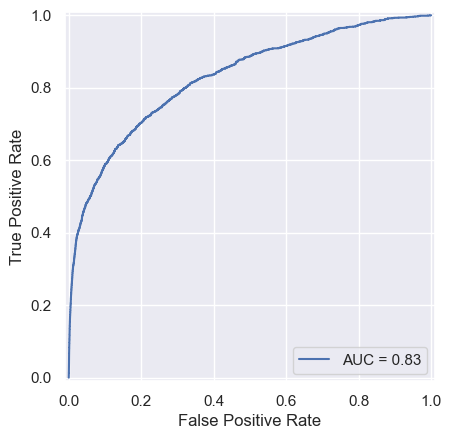

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(test_results['default'], test_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

In [50]:
# train_data_proc.to_csv('train_processed_data_for_2012.csv', index=False)
# test_data_proc.to_csv('test_processed_data_for_2012.csv', index=False)

## saving components for harness

In [58]:
growth_features = [
    'id',
    'stmt_date',
    'net_income',
    'sales'
]

In [59]:
train_data_proc

,Unnamed: 0,id,stmt_date,HQ_city,legal_struct,ateco_sector,def_date,fs_year,asst_intang_fixed,asst_tang_fixed,...,sales,sales_growth,sales_growth_quantile,sales_growth_quantile_values,cash_assets_ratio,cash_assets_ratio_quantile,cash_assets_ratio_quantile_values,dscr,dscr_quantile,dscr_quantile_values
3,22,520288,2007-12-31,28.0,SRL,14.0,NaT,2007,126603.0,1127807.0,...,2041155.0,0.000000,19,0.010524,0.008071,23,0.015813,11.280124,39,0.004833
1,18,520288,2008-12-31,28.0,SRL,14.0,NaT,2008,256438.0,1181416.0,...,967389.0,-0.526058,5,0.031686,0.002570,16,0.017604,0.926243,13,0.010204
2,19,520288,2009-12-31,28.0,SRL,14.0,NaT,2009,194046.0,1152014.0,...,638687.0,-0.339783,7,0.025480,0.005310,21,0.016470,1.918641,20,0.012293
4,23,520288,2010-12-31,28.0,SRL,14.0,NaT,2010,130973.0,1136731.0,...,564622.0,-0.115964,12,0.015813,0.003440,18,0.016469,0.253106,10,0.021958
0,17,520288,2011-12-31,28.0,SRL,14.0,NaT,2011,67537.0,1137566.0,...,538081.0,-0.047007,16,0.009667,0.001070,12,0.016171,0.406302,11,0.017126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776130,4437676,98111220178,2011-12-31,17.0,SRL,70.0,NaT,2011,0.0,54284.0,...,41583.0,0.386100,33,0.010085,0.002758,17,0.016231,-115.380952,2,0.030493
776132,4437705,98120940170,2008-12-31,17.0,SRU,38.0,NaT,2008,6749.0,111056.0,...,2279183.0,0.000000,19,0.010524,0.472416,51,0.012590,3.993937,29,0.005490
776131,4437703,98120940170,2009-12-31,17.0,SRU,38.0,NaT,2009,8640.0,125236.0,...,1931329.0,-0.152622,11,0.016589,0.289645,49,0.006325,-1.864468,6,0.050361
776134,4437709,98120940170,2010-12-31,17.0,SRU,38.0,NaT,2010,16127.0,72130.0,...,2164420.0,0.120689,28,0.007399,0.119598,44,0.008235,0.659516,12,0.013665
